In [1]:
from data import get_data
from neural_network import NeuralNetwork
from randomforest.randomForestInterface import RandomForest
from grad_boosting_interface import *

import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.colors as mcolors


In [2]:
#converting data into binary problem (gradient boosting)

def convert_data(y, pos_class, neg_class1, neg_class2):
    zero_count = 0
    one_count = 0

    for i in range(0, len(y)):
        if y[i] == pos_class:
            y[i] = 1
            one_count += 1
        else:
            if y[i] == neg_class1 or y[i] == neg_class2:
                y[i] = 0
                zero_count += 1


    return zero_count, one_count

In [3]:
train_X, train_y, val_X, val_y, test_X, test_y = get_data()

In [5]:
models = [NeuralNetwork(), RandomForest(), Grad_Boosting_Interface(learning_rate=0.01, boosting_rounds=5, max_depth=3, leaves=8),
         Grad_Boosting_Interface(learning_rate=0.9, boosting_rounds=1, max_depth=3, leaves=4), 
          Grad_Boosting_Interface(learning_rate=0.4698, boosting_rounds=4, max_depth=3, leaves=6)]

#got best hyperparams from optuna trials
best_acc = 0
best_model = models[2]

modelNames = ["Neural Network", "Random Forest", "Gradient Boosting", "Gradient Boosting", "Gradient Boosting"]

count = 0

for i in range(0, len(models)):
    
    
    #get class 1 for grad boosting
    if modelNames[i] == "Gradient Boosting":
        train_X, train_y, val_X, val_y, test_X, test_y = get_data()
        
        if count == 0:
            train_zero_count, train_one_count = convert_data(train_y, 0, 1, 2)
            val_zero_count, val_one_count = convert_data(val_y, 0, 1, 2)
            test_zero_count, test_one_count = convert_data(test_y, 0, 1, 2)

            models[i].one_count = train_one_count
            models[i].zero_count = train_zero_count
            count += 1
        
        elif count == 1: 
            
            class_2_train_zero_count, class_2_train_one_count = convert_data(train_y, 1, 0, 2)
            class_2_val_zero_count, class_2_val_one_count = convert_data(val_y, 1, 0, 2)
            class_2_test_zero_count, class_2_test_one_count = convert_data(test_y, 1, 0, 2)

            models[i].one_count = class_2_train_one_count
            models[i].zero_count = class_2_train_zero_count
            count += 1
        
        else:
            if count == 2:
                class_3_train_zero_count, class_3_train_one_count = convert_data(train_y, 2, 0, 1)
                class_3_val_zero_count, class_3_val_one_count = convert_data(val_y, 2, 0, 1)
                class_3_test_zero_count, class_3_test_one_count = convert_data(test_y, 2, 0, 1)

                models[i].one_count = class_3_train_one_count
                models[i].zero_count = class_3_train_zero_count
                count += 1
        
        models[i].train(train_X, train_y, val_X, val_y)
        y_pred = models[i].predict(test_X)
        acc = models[i].accuracy(y_pred, test_y)
        
        #save best model and test set for it
        if acc > best_acc:
            best_model = models[i]
            best_model_test_y = test_y
            best_model_y_pred = y_pred 

       
        

        
    else:
        models[i].train(train_X, train_y, val_X, val_y)
    

print(best_model)
    


Finished training! Time elapsed: 120.15516090393066
the current accuracy of this tree (Gradient boosting) on test set: 89.43661971830986
feature importances: [0.         0.         0.         0.01129208 0.         0.
 0.         0.         0.60236885 0.03385932 0.         0.
 0.         0.0280127  0.         0.         0.03947507 0.28499197
 0.         0.         0.        ]

the current accuracy of this tree (Gradient boosting) on test set: 90.84507042253522
feature importances: [0.         0.         0.         0.         0.         0.
 0.         0.22921534 0.59257106 0.17821359 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]

the current accuracy of this tree (Gradient boosting) on test set: 97.88732394366197
feature importances: [0.         0.         0.         0.         0.         0.
 0.         0.13039737 0.02881021 0.24047257 0.         0.
 0.         0.07181807 0.         0.         0.         0.52850178
 0.        

In [21]:
predictions = []
outputs = []
confusion_matrices = []
accuracies = []
recalls = []
precisions = []
f1s = []

#add to models list best model
models = models[0:2] + [best_model]



for i in range(0, len(models)):
    if modelNames[i] != "Gradient Boosting":
        output = models[i].predict(test_X)
        pred = np.argmax(output.data, axis=1)
        predictions.append(pred)
        accuracies.append(accuracy_score(test_y, pred))


    else:
        pred = best_model_y_pred
        acc = models[i].accuracy(y_pred, test_y)
        pred[:] = [1 if x > 0 else 0 for x in pred]
        pred = [int(i) for i in pred]
        accuracies.append(acc)

        #print(test_y)
        #print(pred)

    #if models[i] == "Gradient Boosting":
    #    print("confusion matrix: " + confusion_matrix(test_y, pred))
   
    confusion_matrices.append(confusion_matrix(test_y, pred))
    precisions.append(precision_score(test_y, pred, average=None, zero_division=1))
    recalls.append(recall_score(test_y, pred, average=None, zero_division=1))
    f1s.append(f1_score(test_y, pred, average=None))
        
    if modelNames[i] != "Gradient Boosting":
        outputs.append(output)

#print()
print(confusion_matrices)

the current accuracy of this tree (Gradient boosting) on test set: 97.88732394366197
feature importances: [0.         0.         0.         0.         0.         0.
 0.         0.13039737 0.02881021 0.24047257 0.         0.
 0.         0.07181807 0.         0.         0.         0.52850178
 0.         0.         0.        ]

[array([[348,  37,   3],
       [  7,   7,  24],
       [  0,   0,   0]]), array([[354,  30,   4],
       [  5,  17,  16],
       [  0,   0,   0]]), array([[384,   4],
       [  5,  33]])]


In [27]:
print("Accuracies:")
for i in range(len(models)):
    print(f"{modelNames[i]} has an accuracy of {accuracies[i]}")


Accuracies:
Neural Network has an accuracy of 0.8333333333333334
Random Forest has an accuracy of 0.8708920187793427
Gradient Boosting has an accuracy of 97.88732394366197


In [28]:
print("F1 Scores:")
for i in range(len(models)):
    print(f"{modelNames[i]} has an F1 score of {f1s[i]}.")


F1 Scores:
Neural Network has an F1 score of [0.93674293 0.17073171 0.        ].
Random Forest has an F1 score of [0.94779116 0.4        0.        ].
Gradient Boosting has an F1 score of [0.98841699 0.88      ].


In [30]:
print("Precisions:")
for i in range(len(models)):
    print(f"{modelNames[i]} has a precision score of {precisions[i]}.")


Precisions:
Neural Network has a precision score of [0.98028169 0.15909091 0.        ].
Random Forest has a precision score of [0.98607242 0.36170213 0.        ].
Gradient Boosting has a precision score of [0.98714653 0.89189189].


In [31]:
print("Recalls:")
for i in range(len(models)):
  print(f"{modelNames[i]} has a recall score of {recalls[i]}.")


Recalls:
Neural Network has a recall score of [0.89690722 0.18421053 1.        ].
Random Forest has a recall score of [0.91237113 0.44736842 1.        ].
Gradient Boosting has a recall score of [0.98969072 0.86842105].


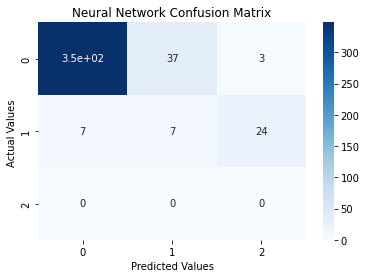

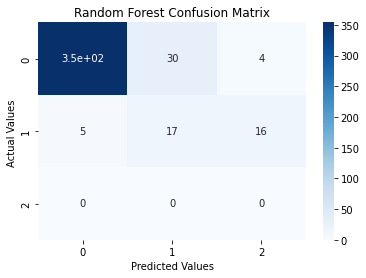

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (3).

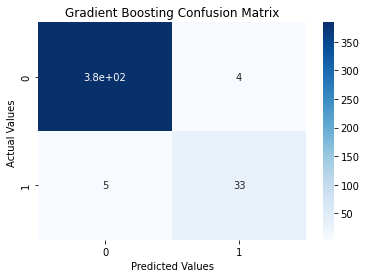

In [38]:
for i in range(len(models)):
    
    ax = sn.heatmap(confusion_matrices[i], annot=True, cmap='Blues')
    ax.set_title(f'{modelNames[i]} Confusion Matrix')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values ')
    
    #ax2 = sn.heatmap(confusion_matrices[i], annot=True, cmap='Blues')
    #ax2.set_title(f'{modelNames[i]} Confusion Matrix')
    #ax2.set_xlabel('Predicted Values')
    #ax2.set_ylabel('Actual Values ')

    if models[i] == "Gradient Boosting":
        ax2.xaxis.set_ticklabels([0, 1])
        ax2.yaxis.set_ticklabels([0, 1])
        plt.show()
        

    else:
        ax.xaxis.set_ticklabels([0, 1, 2])
        ax.yaxis.set_ticklabels([0, 1, 2])
        plt.show()

In [34]:
# Adapted from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
n_values = np.max(test_y) + 1
test_onehot = np.eye(n_values)[test_y]
plt.figure()
for idx, output in enumerate(outputs):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_values):
        fpr[i], tpr[i], _ = roc_curve(test_onehot[:, i], output[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(
        test_onehot.ravel(), outputs[0].ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    lw = 2
    plt.plot(
        fpr[2],
        tpr[2],
        color=list(mcolors.TABLEAU_COLORS.values())[idx],
        lw=lw,
        label=f"ROC curve for {modelNames[idx]} (area = {roc_auc[2]:0.2f})",
    )

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [852, 1278]

<Figure size 432x288 with 0 Axes>